In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
#import bambi as bmb
import xarray as xr
import random
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('paper')
sns.set_style('ticks')
plt.rc("axes.spines", top=False, right=False)
with matplotlib.style.context('arviz-doc'):
    az_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sns.set_palette(az_colors)

def origo(ax=None):
    if ax is None:
        ax = plt.gca()
    x, y = ax.get_xlim(), ax.get_ylim()
    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    plt.ylim(min(0, miny), max(0, maxy))
    plt.xlim(min(0, minx), max(0, maxx))

class columns:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)
        

In [2]:
# scale = 0.35
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context().items() if v is not None])
# d['figure.figsize'] = [1.8, 1.3]
# matplotlib.rcParams.update(d)
# make context for with statement:
# #matplotlib.style.context(d)

In [3]:
# plt.plot(np.random.random(10), np.random.random(10)-10)
# origo()

In [4]:
#Disable annoying "UserWarning: The figure layout has changed to tight" message
import warnings
warnings.filterwarnings('ignore', category=UserWarning
                        # , module='seaborn'
                       )
warnings.filterwarnings('ignore', category=FutureWarning,
                        # module='matplotlib'
                       )

# Read in data

Filter based on callability and remove X chromosome and adjust for missing coverage by extrapolating

In [5]:
data = pd.read_csv('Reduced_Ne_Pi_recomb.csv')
#data.full_species.unique()

In [6]:
data = data[data['freq_mean']>0.7]
data = data[data['chr']!='chrX']
data['corrected_pi'] = data['PI']*data['freq_mean']

In [7]:
selected_groups = ['Gorilla_gorilla', 'Chiropotes_albinasus', 'Saimiri_ustus']
#selected_groups = data.full_species.unique()[:50]

In [8]:
# # subset data for testing
# data = data.loc[(data['chr'] == 'chr1') & (data.full_species.isin(selected_groups))]
# data = data.loc[(data['chr'] == 'chr1')]
# data = data.loc[(data.full_species.isin(selected_groups))]
data.reset_index(drop=True, inplace=True)
data.head()

Unnamed: 0           genus       species                 full_species  \
0           2  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
1           3  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
2           4  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
3           5  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   
4           6  Allenopithecus  nigroviridis  Allenopithecus_nigroviridis   

           MEAN        MEDIAN       NE_MEAN     NE_MEDIAN  freq_mean  \
0  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.809708   
1  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.716477   
2  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.784308   
3  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.747552   
4  8.357479e-09  8.297569e-09  52454.392022  48795.239046   0.783023   

   cm_per_mb   chr        PI  corrected_pi  
0   0.032423  chr1  0.001810      0.001466  
1   1.734505  chr1  0.002047      0.001466  
2   1.056430  chr1  0.002565      0.002012  
3   0.420616  chr1  0.001845      0.001379  
4   1.470184  chr1  0.001713      0.001342

In [9]:
data.full_species.unique()

array(['Allenopithecus_nigroviridis', 'Allochrocebus_lhoesti',
       'Allochrocebus_preussi', 'Allochrocebus_solatus',
       'Alouatta_belzebul', 'Alouatta_caraya', 'Alouatta_discolor',
       'Alouatta_juara', 'Alouatta_macconnelli', 'Alouatta_nigerrima',
       'Alouatta_palliata', 'Alouatta_puruensis', 'Alouatta_seniculus',
       'Aotus_azarae', 'Aotus_griseimembra', 'Aotus_trivirgatus',
       'Aotus_vociferans', 'Arctocebus_calabarensis', 'Ateles_belzebuth',
       'Ateles_chamek', 'Ateles_geoffroyi', 'Ateles_marginatus',
       'Ateles_paniscus', 'Cacajao_ayresi', 'Cacajao_calvus',
       'Cacajao_hosomi', 'Cacajao_melanocephalus', 'Callimico_goeldii',
       'Callithrix_geoffroyi', 'Callithrix_jacchus', 'Callithrix_kuhlii',
       'Cebuella_niveiventris', 'Cebuella_pygmaea', 'Cebus_albifrons',
       'Cebus_olivaceus', 'Cebus_unicolor', 'Cercocebus_chrysogaster',
       'Cercocebus_lunulatus', 'Cercocebus_torquatus',
       'Cercopithecus_ascanius', 'Cercopithecus_cephus',
  

In [10]:
np.log10(data['NE_MEDIAN'].mean()), np.log10(data['NE_MEDIAN']).mean()

(4.845759193883429, 4.749171266594735)

# Transform data

In [11]:
species_encoder = LabelEncoder()

gr = data.groupby('full_species')

df = pd.DataFrame(dict(
    
    # log scale and z transform Ne globally
    Ne = data.NE_MEDIAN.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # log scale and z transform recombination rate by species
    rec_rate = gr.cm_per_mb.transform(np.log1p).transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # z transform pi by species
    pi = gr.corrected_pi.transform(lambda sr: (sr - sr.mean()) / sr.std()),

    # species name for each observation
    full_species = data.full_species,

    # species to integer transform
    species = species_encoder.fit_transform(data.full_species)
    
))

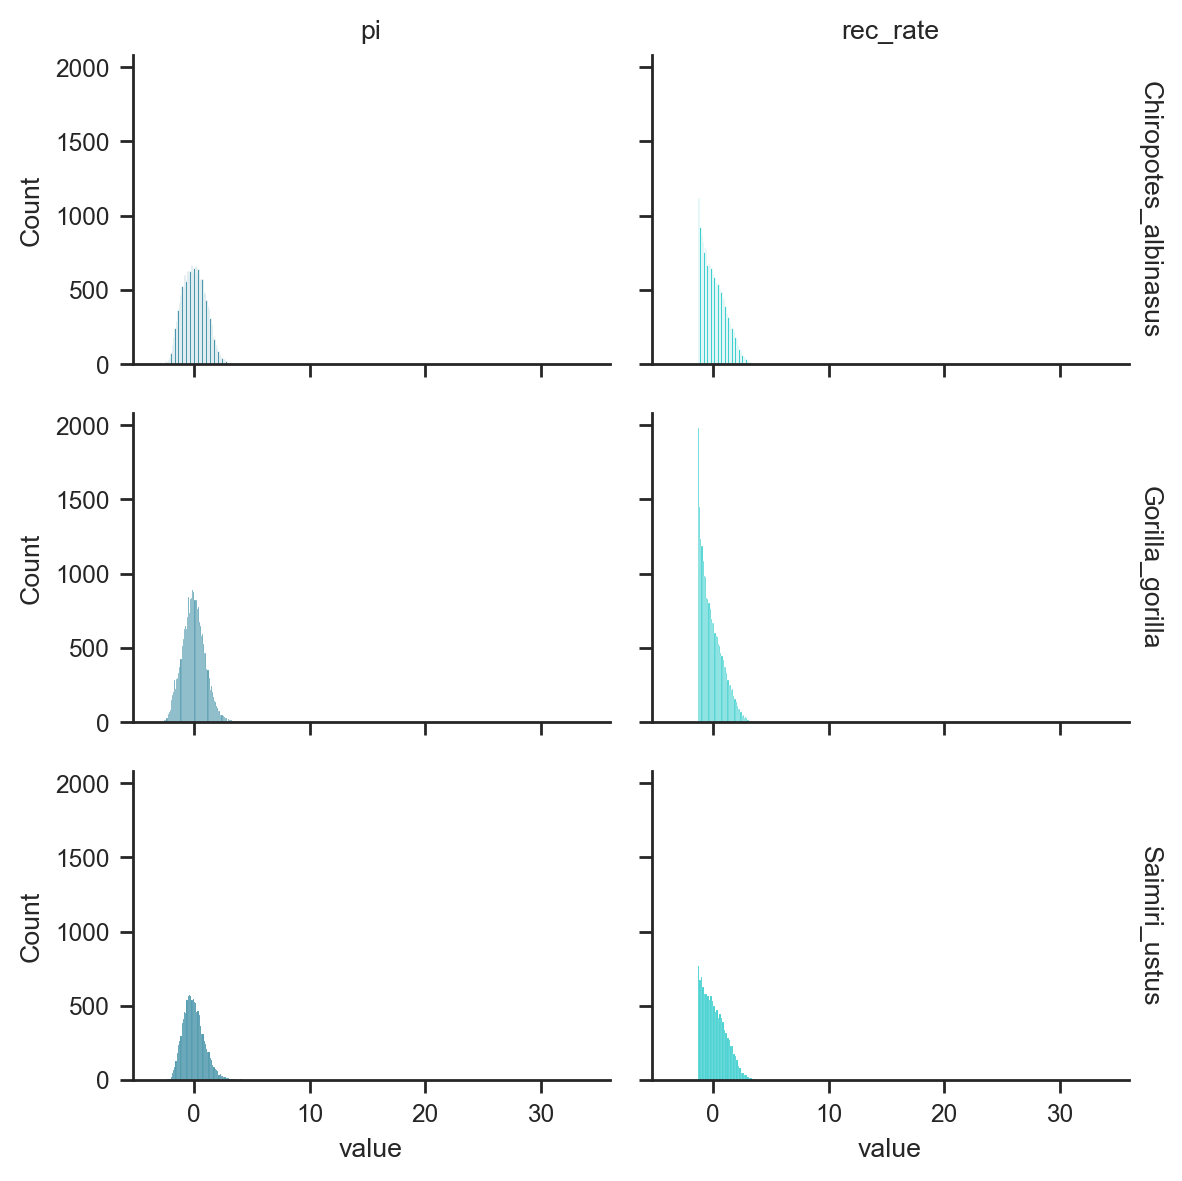

In [12]:
plot_df = df.loc[df.full_species.isin(selected_groups)].melt(id_vars='full_species', value_vars=['pi', 'rec_rate'])
g = sns.FacetGrid(plot_df, col="variable", row="full_species", hue="variable", margin_titles=True, height=2, aspect=1.5)
g.map_dataframe(sns.histplot, x="value")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    title = ax.get_title()
    ax.set_title(title, rotation=0)
plt.tight_layout()

In [13]:
# population_idx = 
# background_pi = 
# admixture_prop = 

# population_label = 
# dist_from_hybzone = 

# Observations

In [14]:
window_y_values = df.pi.values
window_x_values = df.rec_rate.values
global_group_names = pd.unique(species_encoder.inverse_transform(df.species))
global_group_indices = df.species
global_group_values = df[['full_species', 'Ne']].drop_duplicates().Ne.values

assert len(global_group_names) == len(global_group_values)
assert len(window_y_values) == len(window_x_values)
assert len(window_x_values) == len(global_group_indices)

# Model with independent regressions

In [43]:
model_parallel = pm.Model(coords = {"global_group": global_group_names,
                           "obs_id": np.arange(len(window_x_values))})
non_centered = True

with model_parallel:
    
    window_dependent = pm.ConstantData('window_dependent', window_x_values, dims='obs_id')
    window_independent = pm.ConstantData('window_independent', window_y_values, dims='obs_id')
    global_group_member = pm.ConstantData('global_group_member', global_group_indices, dims='obs_id')
    # global_dependent =  pm.ConstantData('global_dependent', global_group_values, dims='global_group')

    # hyperprior on window_independent ~ window_dependent intercept prior
    hyp_inter_inter = pm.Normal("hyp_inter_inter", mu=0, sigma=1)
    # hyp_inter_slope = pm.Normal("hyp_inter_slope", mu=0, sigma=1)
    
    # hyperprior on window_independent ~ window_dependent slope prior
    # hyp_slope_inter = pm.Normal("hyp_slope_inter", mu=0, sigma=1)
    hyp_slope_slope = pm.Normal("hyp_slope_slope", mu=0, sigma=1)

    # prior on residual variation on global_group intercepts
    group_inter_residual = pm.Normal("group_inter_residual", 0, sigma=1, dims="global_group")
    
    # prior on residual variation on global_group slopes
    group_slope_residual = pm.Normal("group_slope_residual", 0, sigma=1, dims="global_group")

    # prior on window_independent ~ window_dependent intercept for each global_group
    # mu_inter = hyp_inter_inter + hyp_inter_slope * global_dependent
    mu_inter = hyp_inter_inter 
    sigma_inter = pm.Exponential("sigma_inter", 1)
    group_inter = pm.Deterministic("group_inter", mu_inter + group_inter_residual * sigma_inter, dims="global_group")

    # prior on window_independent ~ window_dependent slope for each global_group
    # mu_slope = hyp_slope_inter + hyp_slope_slope * global_dependent
    mu_slope = hyp_slope_slope
    sigma_slope = pm.Exponential("sigma_slope", 1)
    group_slope = pm.Deterministic("group_slope", mu_slope + group_slope_residual * sigma_slope, dims="global_group")
        
    # prior window_independent ~ window_dependent slope for each global_group
    mu_window_independent = group_inter[global_group_member] + group_slope[global_group_member] * window_dependent
    sigma_window_independent = pm.Exponential("sigma_window_independent", 0.01)

    # prior
    WindowIndependent = pm.Normal("Independent", mu=mu_window_independent, sigma=sigma_window_independent, observed=window_independent, dims="obs_id")

In [44]:
%%capture
fig, ax = plt.subplots()
g = pm.model_to_graphviz(model_parallel)
g.graph_attr.update(size="10,10")

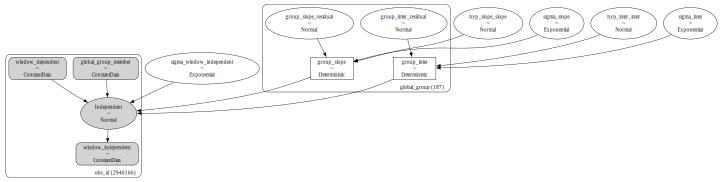

In [45]:
g

## Prior predictive checks

In [46]:
with model_parallel:
    idata_parallel = pm.sample_prior_predictive()

Sampling: [Independent, group_inter_residual, group_slope_residual, hyp_inter_inter, hyp_slope_slope, sigma_inter, sigma_slope, sigma_window_independent]


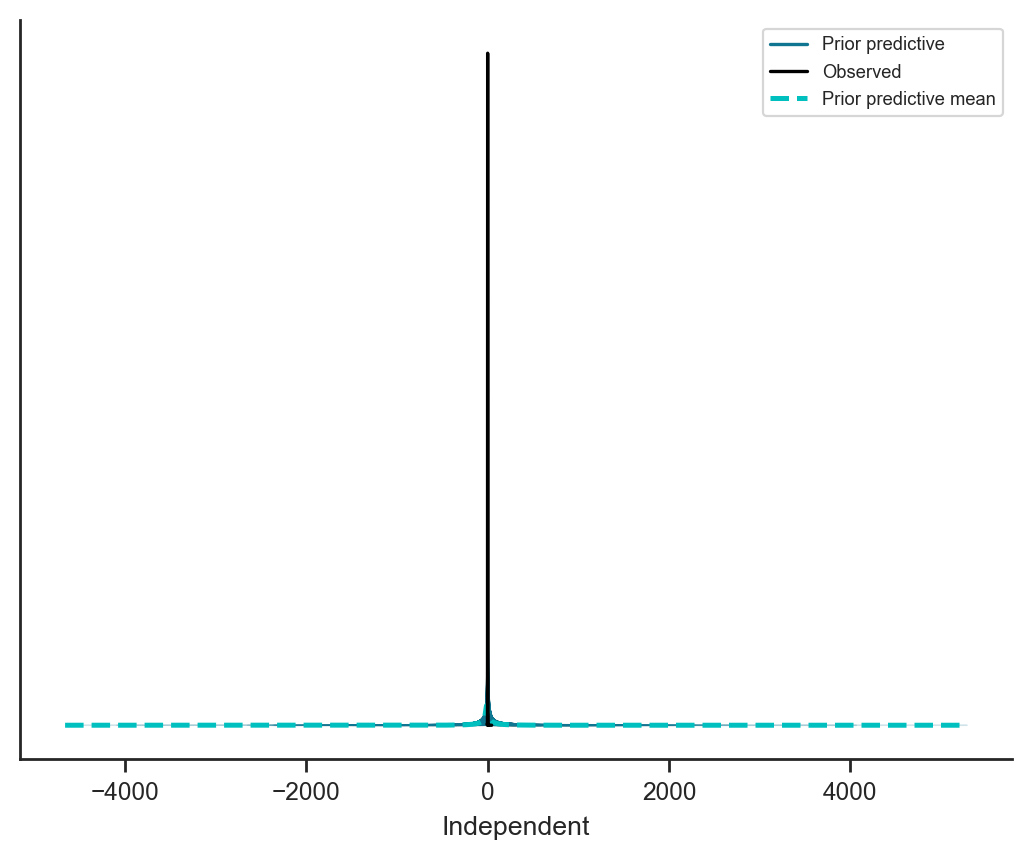

In [47]:
az.plot_ppc(idata_parallel, group='prior') ;

## Model trace

In [48]:
use_cached = True

trace_file = 'model_parallel.nc'
if use_cached and os.path.exists(trace_file):
    with model_parallel:
         trace = az.from_netcdf(trace_file)
else:
    with model_parallel:
        trace = pm.sample(#1000, 
                          target_accept=0.95, 
                          return_inferencedata=True,
                          progressbar=True, 
            # cores=4, chains=4
        )
        trace.to_netcdf(trace_file)

idata_parallel.extend(trace)

## Trace diagnostics

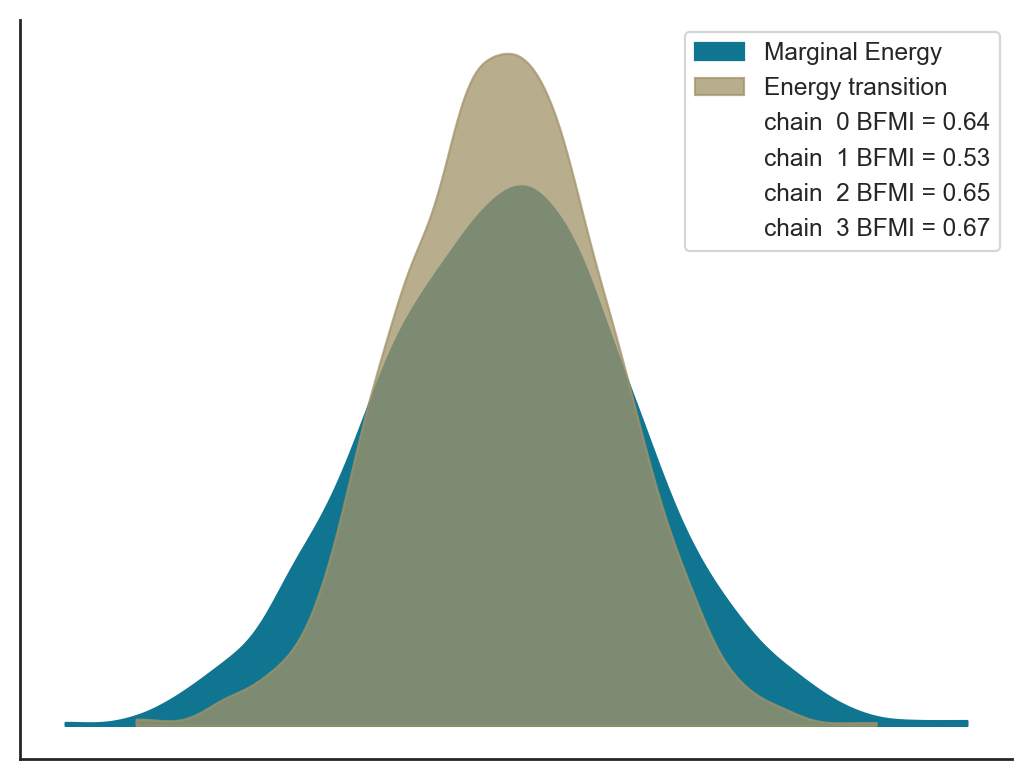

In [49]:
az.plot_energy(idata_parallel);

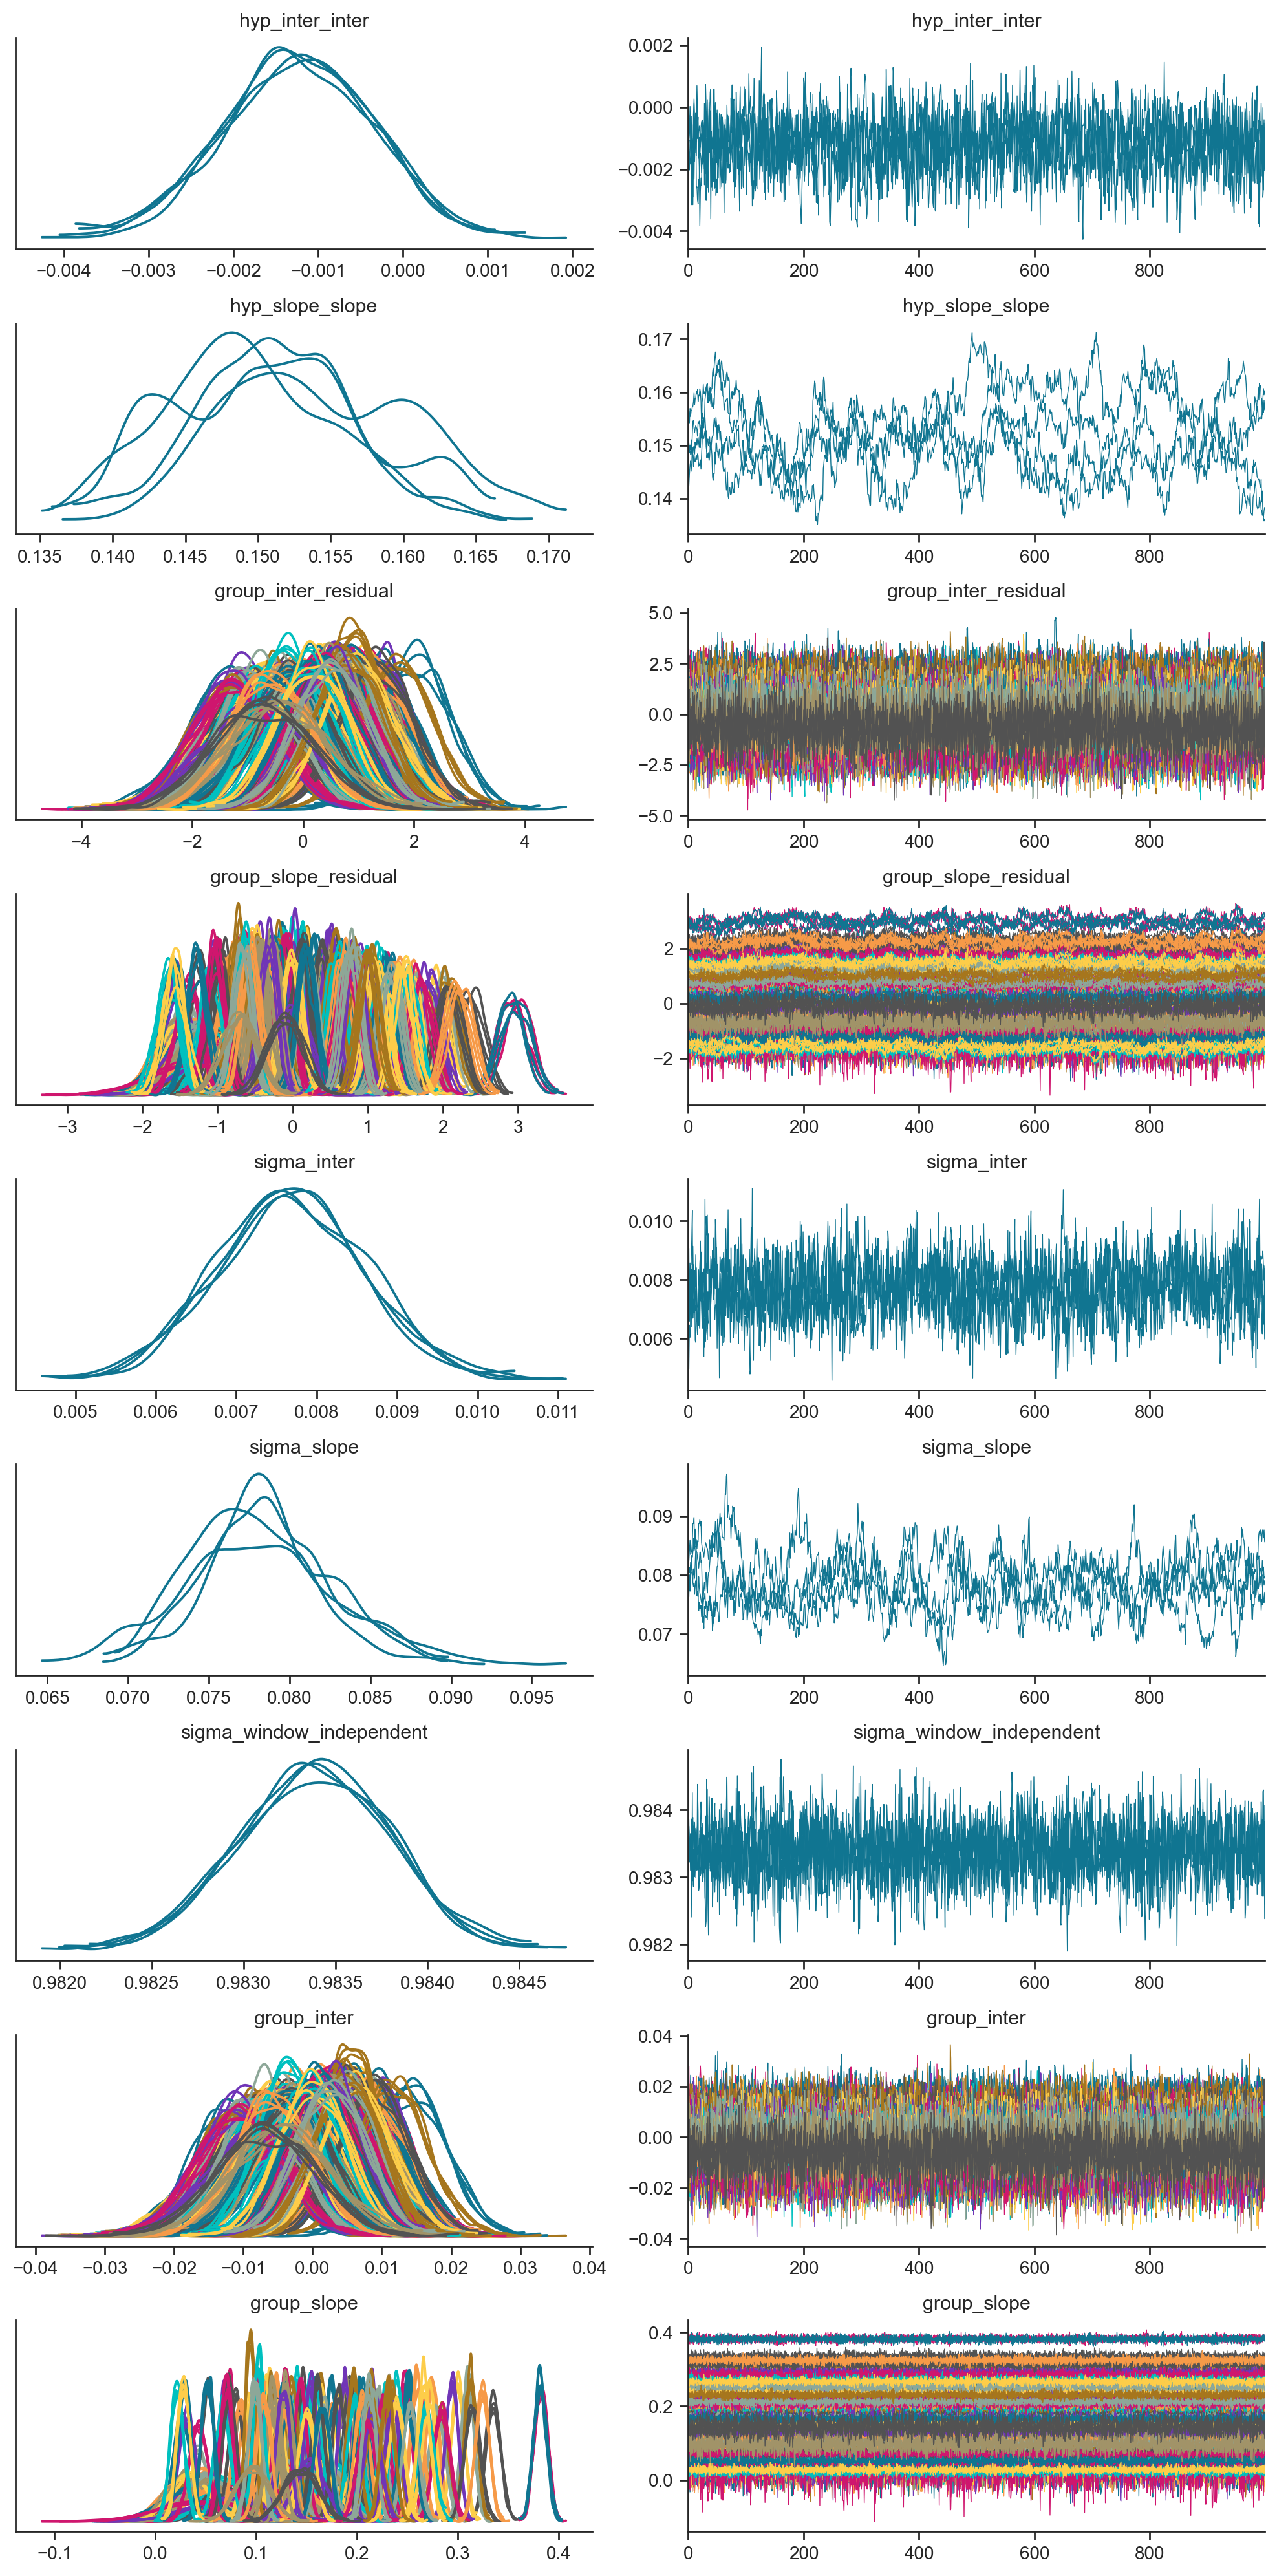

In [50]:
az.plot_trace(idata_parallel,
    # var_names=[],
    compact=True,
    figsize=(10, 20),
    chain_prop=dict(linestyle='-'),
    trace_kwargs=dict(linestyle='-', linewidth=0.5, alpha=1),
             )
plt.tight_layout()

## Posterior predictive checks

In [51]:
# with model_parallel:
#     idata_parallel.extend(pm.sample_posterior_predictive(idata_parallel))

# thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to sample_posterior_predictive
thinned_idata = idata_parallel.sel(draw=slice(None, None, 5))
with model_parallel:
    idata_parallel.extend(pm.sample_posterior_predictive(thinned_idata))

# # generate 5 posterior predictive samples per posterior sample
# expanded_data = idata_parallel.posterior.expand_dims(pred_id=5)
# with model_parallel:
#     idata_parallel.extend(pm.sample_posterior_predictive(expanded_data))

Sampling: [Independent]


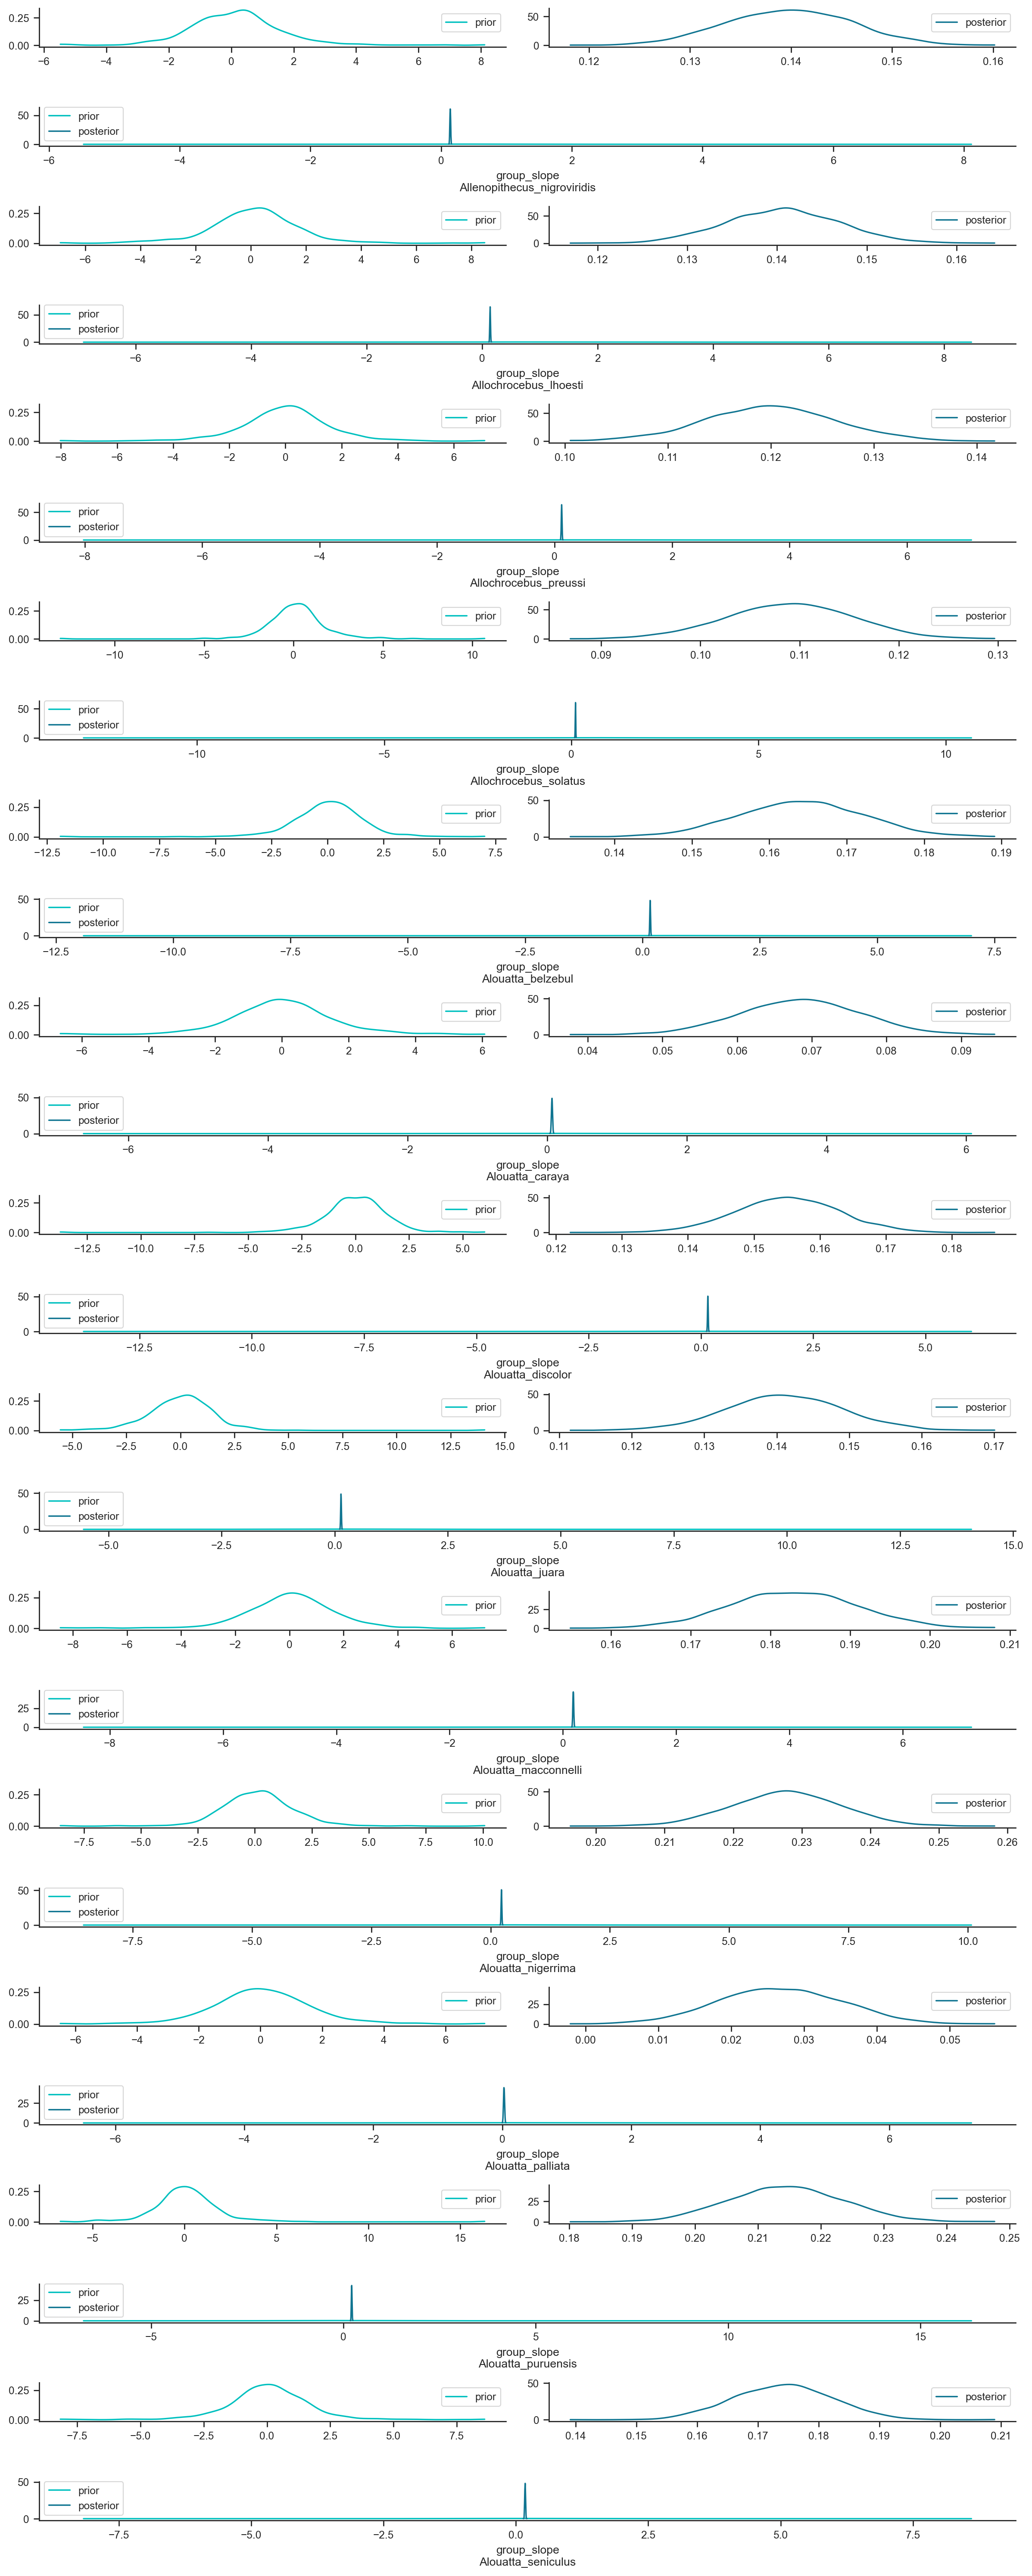

In [52]:
az.plot_dist_comparison(idata_parallel, var_names=["group_slope"], 
#                        coords={"global_group" : ['Macaca_arctoides', 'Macaca_cyclopis']},
                        figsize=(12, 30))
plt.tight_layout()

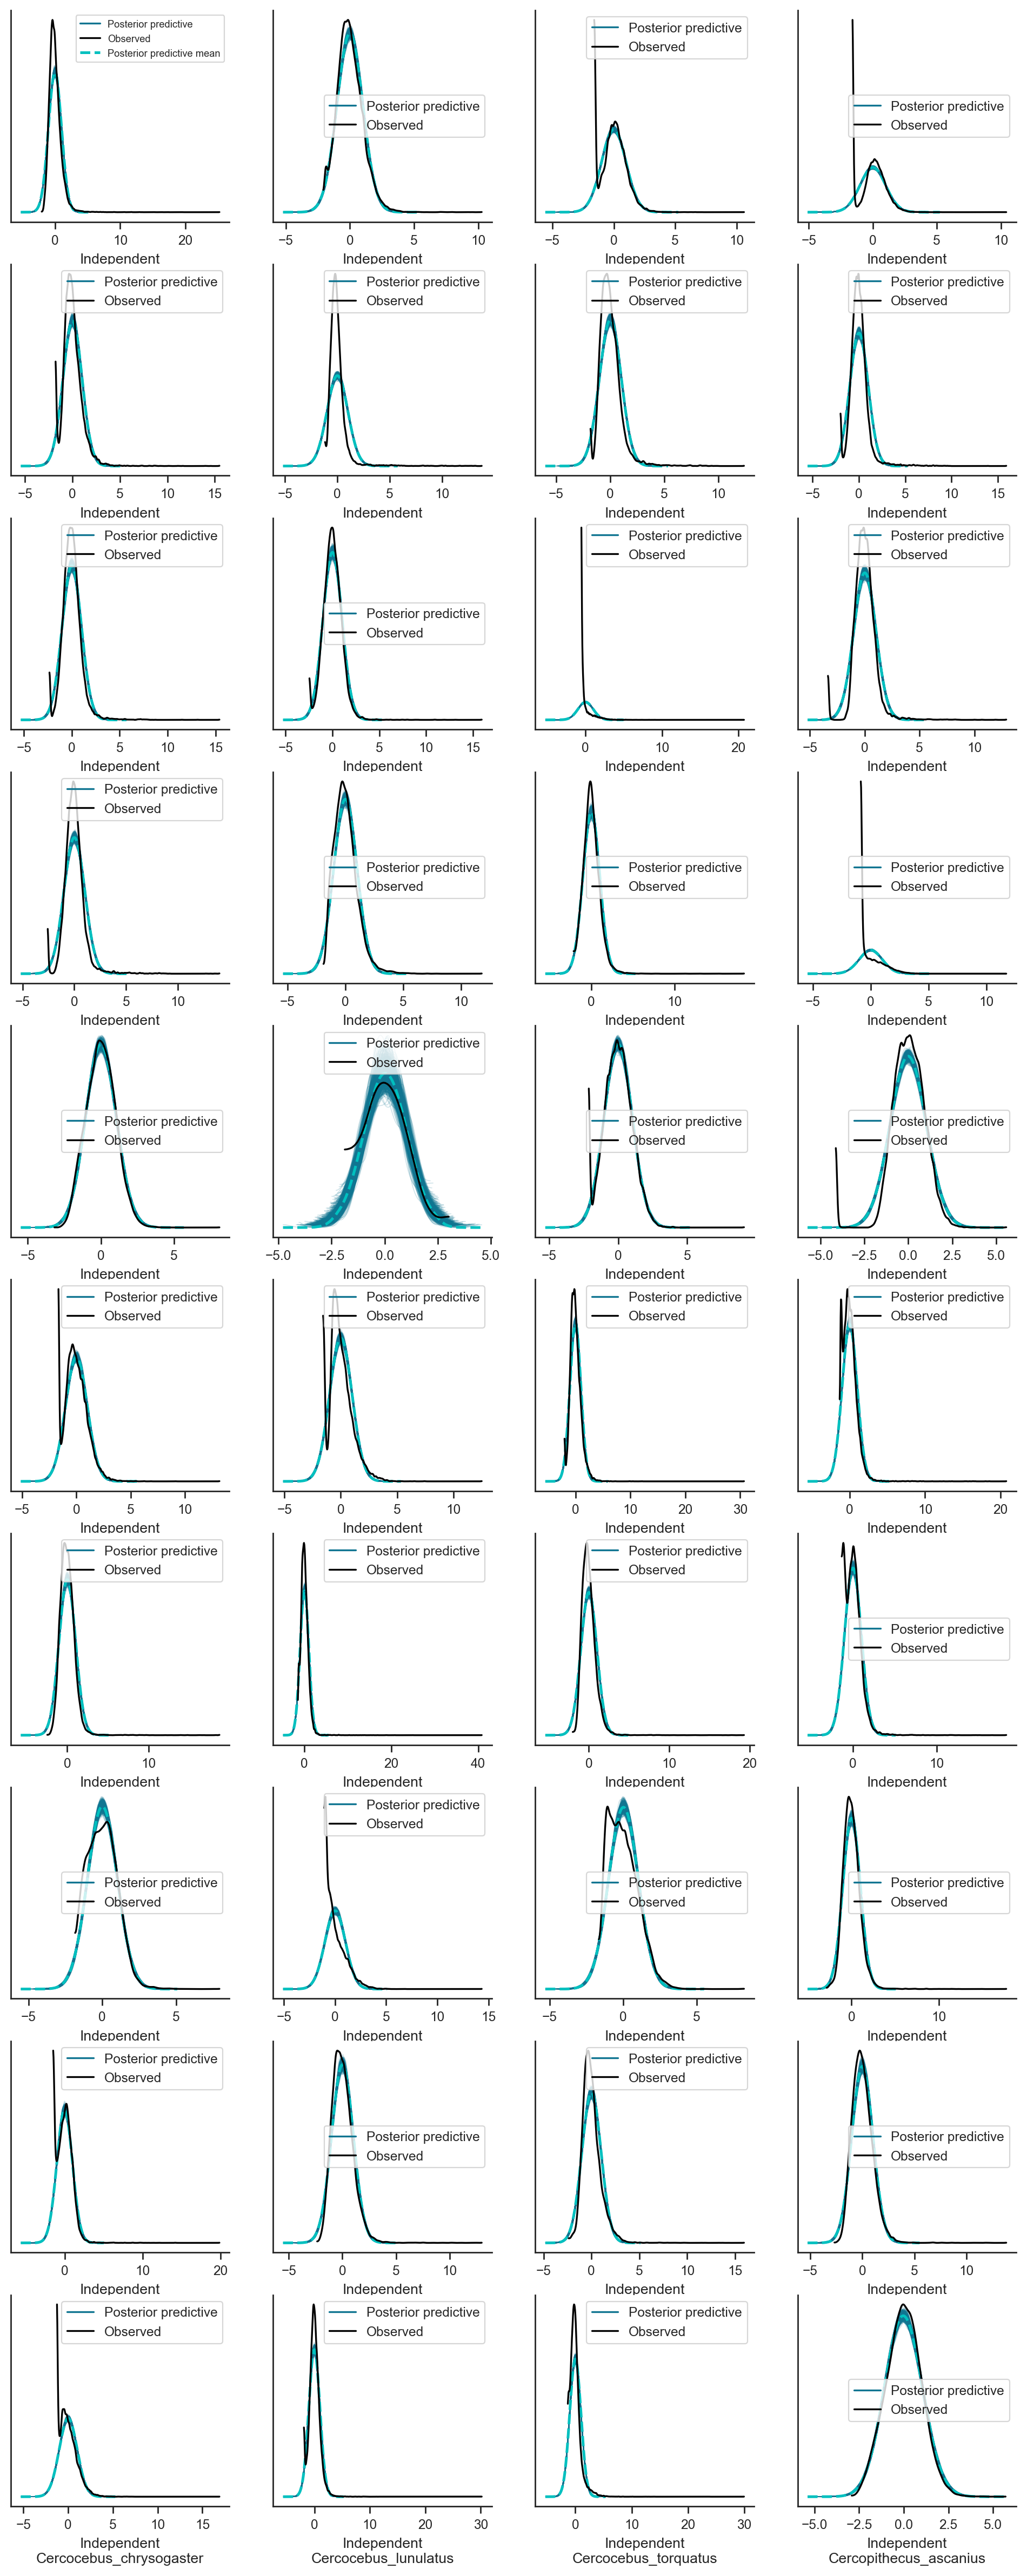

In [53]:
obs_group = idata_parallel.posterior["global_group"][idata_parallel.constant_data["global_group_member"]]
_idata = idata_parallel.assign_coords(obs_id=obs_group, groups="observed_vars")
#_idata = idata.assign_coords(obs_id=obs_group)
az.plot_ppc(_idata, group='posterior',
            # coords={'obs_id': ['Macaca_arctoides', 'Macaca_cyclopis']}, 
            flatten=[], figsize=(12, 30)) ;

In [54]:
# az.plot_ppc(_idata, group='posterior', flatten=[], figsize=(15, 10))
# plt.gca().legend(bbox_to_anchor=(1.1, 1.05))
# plt.tight_layout()

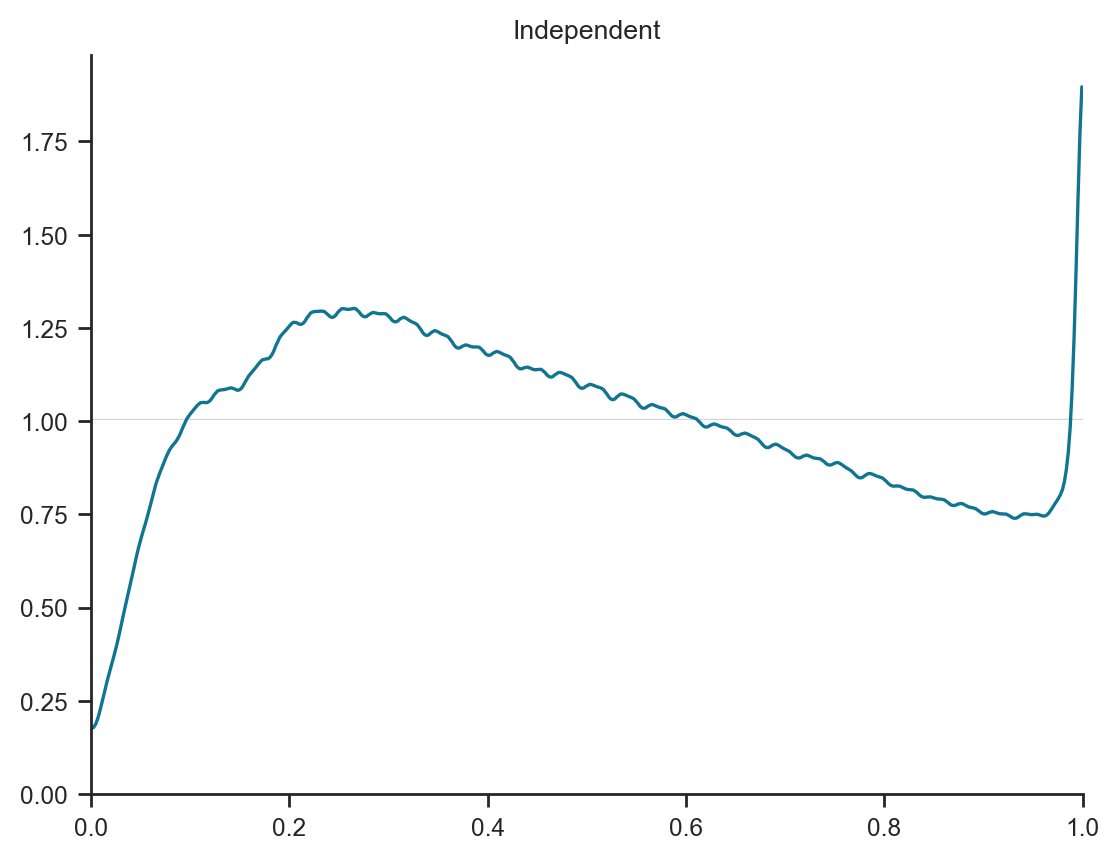

In [55]:
az.plot_bpv(idata_parallel) ;

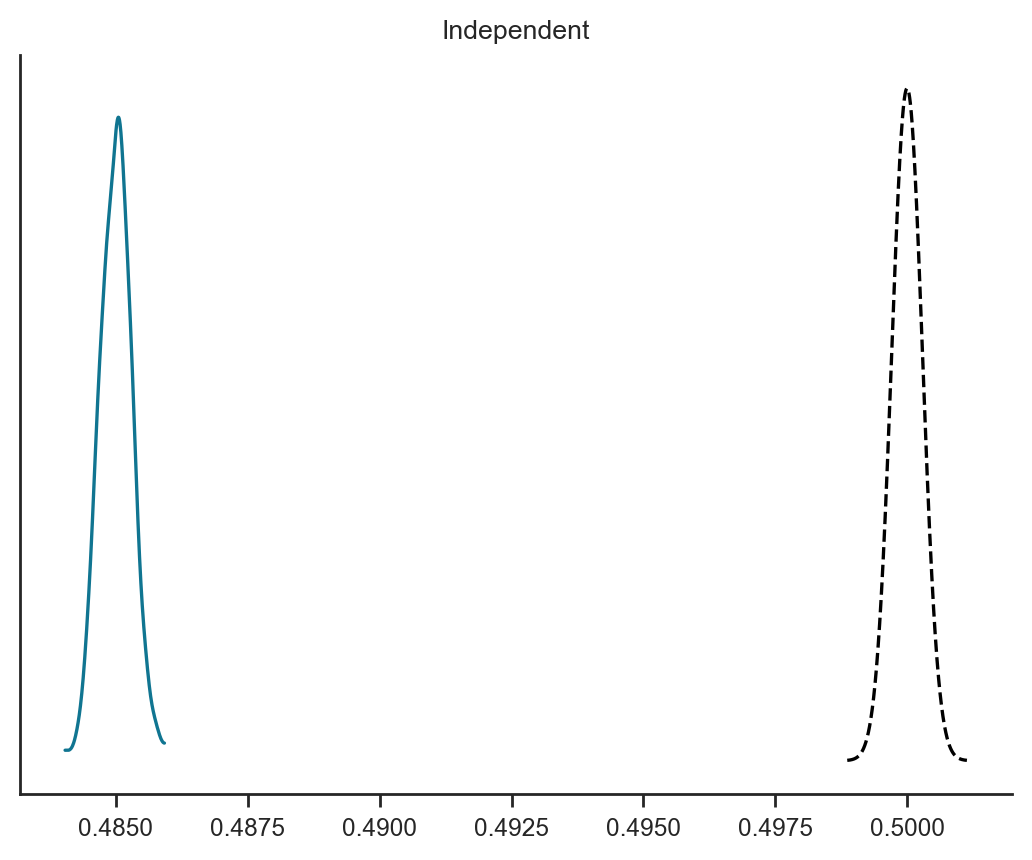

In [56]:
az.plot_bpv(idata_parallel, kind="p_value") ;

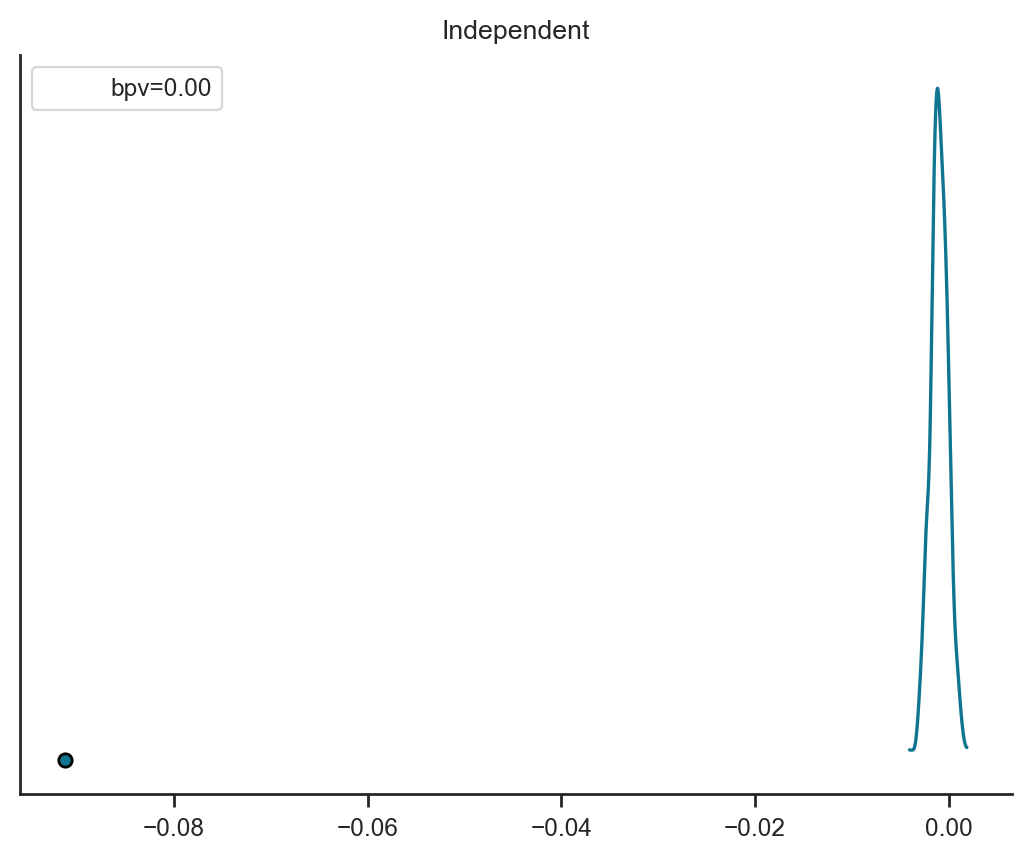

In [57]:
az.plot_bpv(idata_parallel, kind="t_stat", t_stat=lambda x:np.percentile(x, q=50, axis=-1)) ;

# Model performance

## Loo ELPD

In [43]:
# thin a sampled inferencedata by keeping 1 out of every 5 draws before passing it to compute_log_likelihood
thinned_idata = idata_parallel.sel(draw=slice(None, None, 5))
with model_parallel:
    idata_parallel.extend(pm.compute_log_likelihood(thinned_idata))

In [ ]:
loo_parallel = az.loo(idata_parallel)
loo_parallel

In [ ]:
loo_pointwise_parallel = az.loo(idata_parallel, pointwise=True)
loo_parallel

Save as pandas series:

In [65]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # I know ...
    
    loo_parallel.to_hdf('loo_parallel.h5', key='df')
    loo_pointwise_parallel.to_hdf('loo_pointwise_parallel.h5', key='df')    

Turn back into arviz `ELPDData`:

In [67]:
from arviz.stats import ELPDData
loo_parallel = ELPDData(pd.read_hdf('loo_parallel.h5'))
loo_parallel

Computed from 800 posterior samples and 2940166 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4122802.30  5102.07
p_loo      286.87        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                           Count   Pct.
(-Inf, 0.5]   (good)     2938948  100.0%
 (0.5, 0.7]   (ok)          1202    0.0%
   (0.7, 1]   (bad)           16    0.0%
   (1, Inf)   (very bad)       0    0.0%

## Khat

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

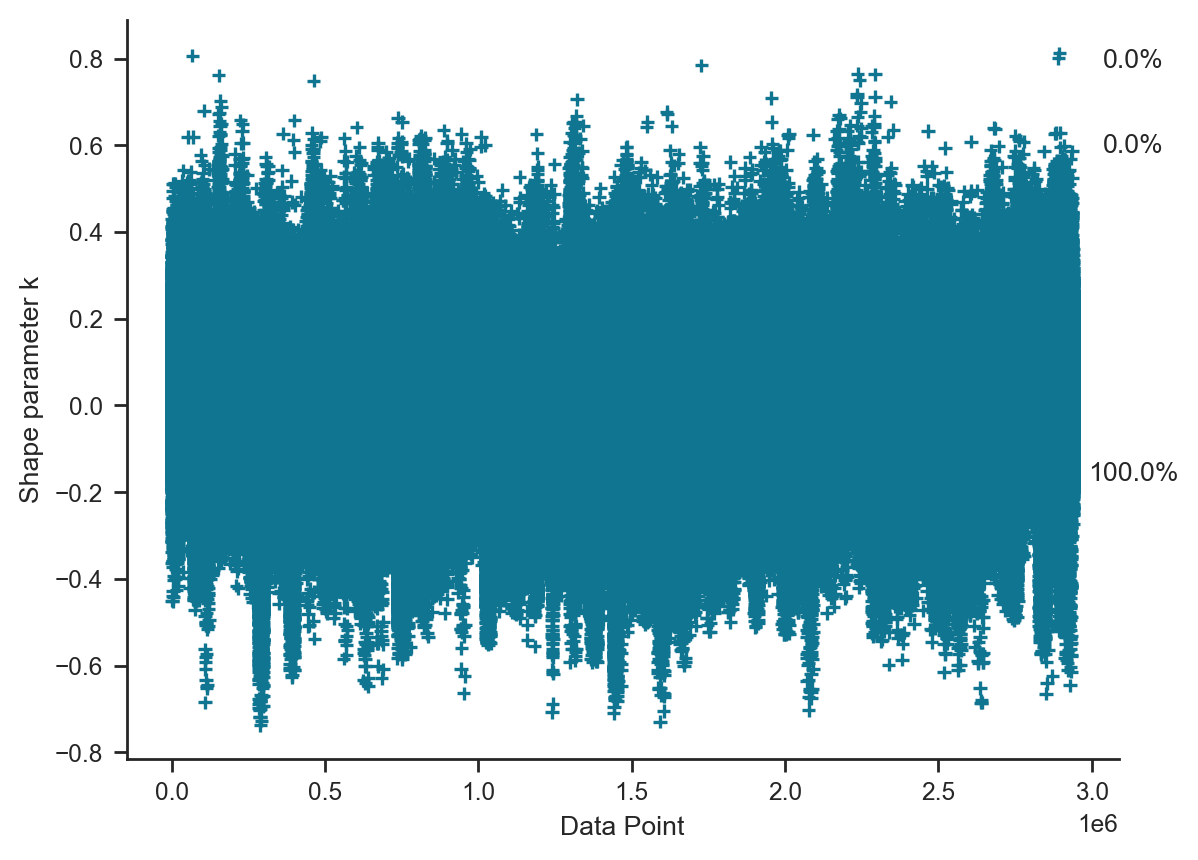

In [68]:
az.plot_khat(loo_parallel, show_bins=True) ;

In [ ]:
az.plot_khat(loo_pointwise_parallel.pareto_k, xlabels=True, threshold=1)

In [ ]:
counties = radon.posterior.County[radon.constant_data.county_idx].values
colors = [
    "blue" if county[-1] in ("A", "N") else "green" for county in counties
]
az.plot_khat(loo_radon, color=colors)

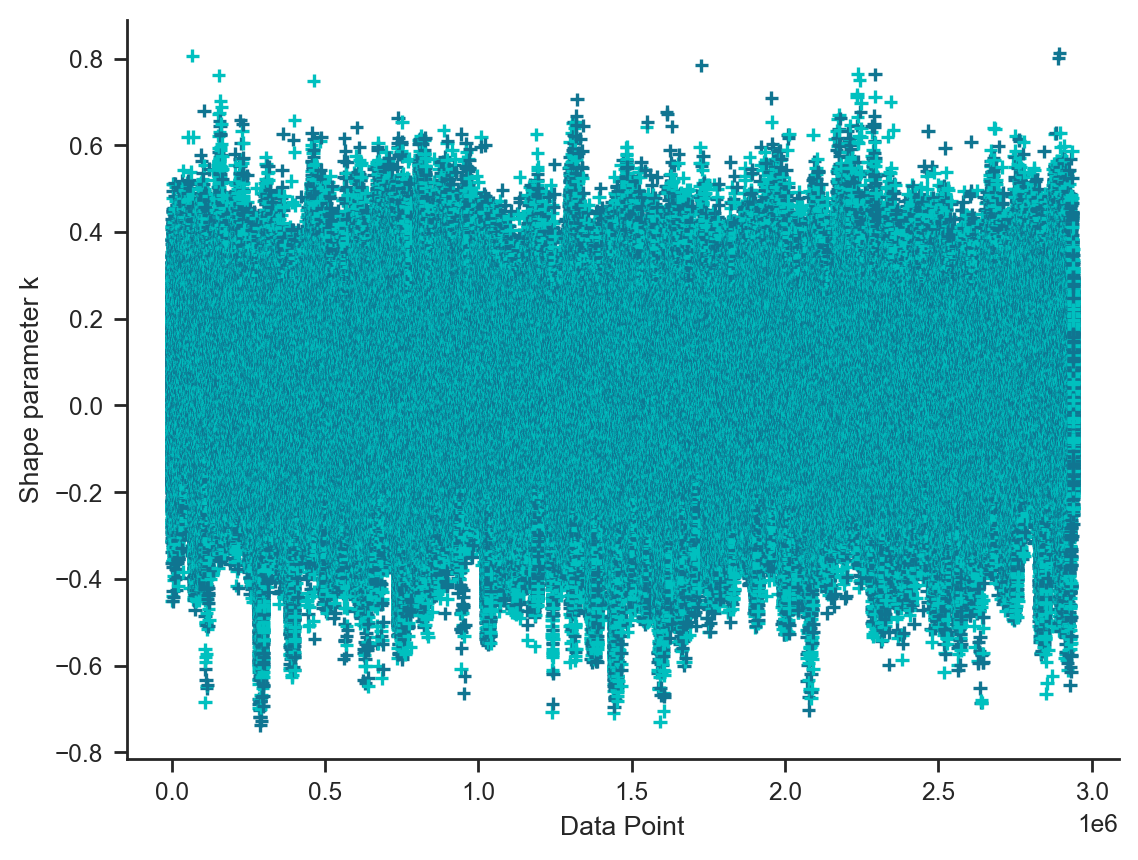

In [72]:
groups = idata_parallel.posterior.global_group[idata_parallel.constant_data.global_group_member].values
colors = [
    "C0" if i % 2 else "C1" for (i, gr) in enumerate(groups)
]
az.plot_khat(loo_parallel, color=colors) ;

## WAIC

In [73]:
waic_parallel = az.waic(idata_parallel)
waic_parallel

In [74]:
waic_pointwise_parallel = az.waic(idata_parallel, pointwise=True)
waic_pointwise_parallel

In [75]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) # I know ...
    
    waic_parallel.to_hdf('waic_parallel.h5', key='df')
    waic_pointwise_parallel.to_hdf('waic_pointwise_parallel.h5', key='df')   

Turn back into arviz `ELPDData`:

In [76]:
from arviz.stats import ELPDData
waic_parallel = ELPDData(pd.read_hdf('waic_parallel.h5'))
waic_pointwise_parallel = ELPDData(pd.read_hdf('waic_pointwise_parallel.h5'))

In [77]:
waic_parallel

Computed from 800 posterior samples and 2940166 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4122801.36  5102.07
p_waic      285.92        -

There has been a warning during the calculation. Please check the results.

In [78]:
waic_pointwise_parallel

Computed from 800 posterior samples and 2940166 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4122801.36  5102.07
p_waic      285.92        -

There has been a warning during the calculation. Please check the results.